# Title of notebook

Brief 1-2 sentence description of notebook.

In [1]:
# Imports of all used packages and libraries
import os
import glob
import bisect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy.signal import butter, filtfilt, hilbert


In [2]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp

## Inputs & Data

Explanation of each input and where it comes from.

In [3]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
CHANNEL_MAPPING_DF = pd.read_excel("../../data/channel_mapping.xlsx")
TONE_TIMESTAMP_DF = pd.read_excel("../../data/rce_tone_timestamp.xlsx", index_col=0)
CHANNEL_MAP_AND_ALL_TRIALS_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")
MERGED_SPIKE_TRIAL_DF = pd.read_pickle("./proc/merged_spike_trial.pkl")

In [5]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000
LFP_SAMPLING_RATE=1000
EPHYS_SAMPLING_RATE=20000
TRIAL_DURATION=10

In [6]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [7]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

In [8]:
ORDER=4
FREQ_BAND = [3, 12]
numerator_b, denominator_a = butter(ORDER, FREQ_BAND, fs=LFP_SAMPLING_RATE, btype='band')

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

# Functions

In [9]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [10]:

def find_closest_nums(list1, list2):
    """
    For each number in list1, find the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of closest numbers from list2 for each number in list1.
    """
    closest_nums = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return it
        if position != len(list2) and list2[position] == num:
            closest_nums.append(num)
        # Else find the closest of the two neighbors
        else:
            if position == 0:
                closest_nums.append(list2[0])
            elif position == len(list2):
                closest_nums.append(list2[-1])
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_nums.append(before if num - before <= after - num else after)

    return closest_nums



In [11]:
def find_closest_indices(list1, list2):
    """
    For each number in list1, find the index of the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of indices of the closest numbers from list2 for each number in list1.
    """
    closest_indices = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return its index
        if position != len(list2) and list2[position] == num:
            closest_indices.append(position)
        # Else find the index of the closest of the two neighbors
        else:
            if position == 0:
                closest_indices.append(0)
            elif position == len(list2):
                closest_indices.append(len(list2) - 1)
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_indices.append(position - 1 if num - before <= after - num else position)

    return closest_indices


## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

- Getting all the timestamps of the LFPs

In [12]:
CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_trial_all_lfp_index"] = CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_index"].apply(lambda x: np.arange(x,x+TRIAL_DURATION*LFP_SAMPLING_RATE))

CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_baseline_all_lfp_index"] = CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_index"].apply(lambda x: np.arange(x-TRIAL_DURATION*LFP_SAMPLING_RATE, x))

In [13]:
CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_trial_all_ephys_index"] = CHANNEL_MAP_AND_ALL_TRIALS_DF["time_stamp_index"].apply(lambda x: np.arange(x,x+EPHYS_SAMPLING_RATE*TRIAL_DURATION, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_baseline_all_ephys_index"] = CHANNEL_MAP_AND_ALL_TRIALS_DF["time_stamp_index"].apply(lambda x: np.arange(x-EPHYS_SAMPLING_RATE*TRIAL_DURATION, x, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

- Filtering all the data

In [14]:
trace_columns = [col for col in CHANNEL_MAP_AND_ALL_TRIALS_DF.columns if "trace" in col]

In [15]:
for col in trace_columns:
    region_name = "_".join(col.split("_")[:2])
    CHANNEL_MAP_AND_ALL_TRIALS_DF["{}_filtered".format(region_name)] = CHANNEL_MAP_AND_ALL_TRIALS_DF[col].apply(lambda x: filtfilt(numerator_b, denominator_a, x, padtype=None))

    CHANNEL_MAP_AND_ALL_TRIALS_DF["{}_phase".format(region_name)] = CHANNEL_MAP_AND_ALL_TRIALS_DF["{}_filtered".format(region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))
    


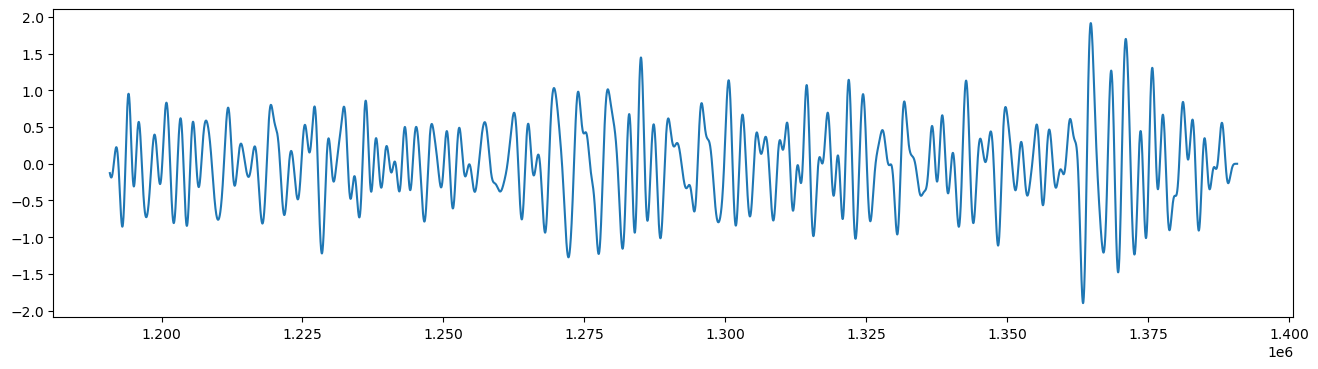

In [16]:

plt.figure(figsize=(16,4))
plt.plot(CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_baseline_all_ephys_index"].iloc[0], CHANNEL_MAP_AND_ALL_TRIALS_DF["BLA_trial_filtered"].iloc[0])
# plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

Text(0, 0.5, 'Phase (degrees)')

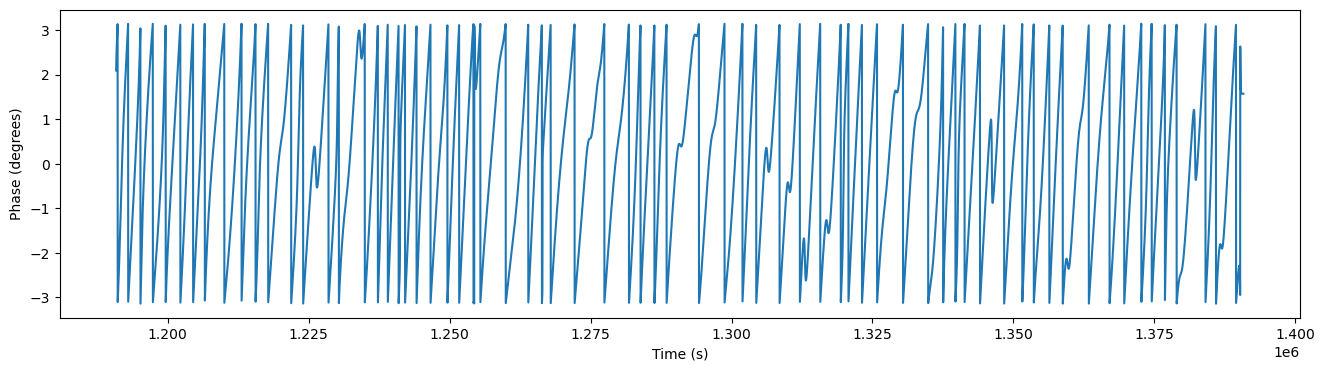

In [17]:
plt.figure(figsize=(16,4))
plt.plot(CHANNEL_MAP_AND_ALL_TRIALS_DF["lfp_baseline_all_ephys_index"].iloc[0], CHANNEL_MAP_AND_ALL_TRIALS_DF["BLA_trial_phase"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
# plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [18]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,BLA_trial_filtered,BLA_trial_phase,LH_baseline_filtered,LH_baseline_phase,LH_trial_filtered,LH_trial_phase,MD_baseline_filtered,MD_baseline_phase,MD_trial_filtered,MD_trial_phase
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.1270232139593776, -0.13550809575176323, -0...","[2.0921499379288093, 2.318664933741562, 2.3488...","[0.056868270266307065, 0.04576024370573059, 0....","[-0.8294859902205611, -0.29035528041932773, -0...","[0.1633071968546726, 0.16612519566931022, 0.16...","[-0.8714076735108721, -0.5086576686505543, -0....","[-0.20688000714736948, -0.2102295128636095, -0...","[2.4658837910421507, 2.997769183878443, 3.0297...","[-0.20527917065687415, -0.19719870709125534, -...","[2.6609099288334126, -2.9291304768028654, -2.8..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.06167014683416184, 0.04540589200067514, 0.0...","[1.1931051596958737, 1.364677985966047, 1.4456...","[-0.6310182399173343, -0.6028305711469237, -0....","[2.70317941107642, -2.8854240753310387, -2.816...","[0.08406742217288202, 0.054967079728184, 0.025...","[1.2979990285889775, 1.4315598190373768, 1.508...","[-0.23284599033521072, -0.19518301488393547, -...","[-2.1967190077622707, -1.9250858812347904, -1....","[0.00897178566523055, -0.02040608637520462, -0...","[1.546744032693701, 1.6197585170264568, 1.6855..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.09910481914715255, 0.10104307136384137, 0.1...","[-0.927968248659119, -0.5873130086540211, -0.5...","[0.1465498150487816, 0.15518114144873194, 0.16...","[-1.214160090156733, -1.1087585375109443, -1.0...","[0.1440232256165005, 0.17112191208887603, 0.19...","[-1.2734754133841686, -1.1716494030565592, -1....","[0.12243278938862083, 0.12378007869477951, 0.1...","[-1.1733709027228445, -1.053112396600152, -1.0...","[0.34646154764149273, 0.3614771084116735, 0.37...","[-0.9720995533787167, -0.682034040817512, -0.6..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[0.8079986776507001, 0.802581616330127, 0.7956...","[-0.7483757898044902, -0.25297448987131416, -0...","[-0.12212974143207109, -0.0897303594412939, -0...","[-2.0406652731308466, -1.8131783573628426, -1....","[0.881736402579422, 0.8389485366589725, 0.7945...","[-0.4412991310421433, 0.2551244873375817, 0.32...","[-0.30059619238390456, -0.26245575725812575, -...","[-2.7000185364019775, -2.1627155132289615, -2....","[0.7752331855274641, 0.7469425432890375, 0.717...","[-0.5479010625727009, 0.09808296574327503, 0.1..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.254415931077215, -0.2409205597620281, -0.2...","[2.582987879734853, -3.0482235776078555, -2.99...","[-0.057397393662318, -0.04698434364269451, -0....","[-2.8402555412201433, -2.1980502765251595, -2....","[0.07969558521319708, 0.09709934263189805, 0.1...","[-1.3590004890828478, -1.292010156609553, -1.2...","[0.

# Plotting phase and LFP

In [19]:
MERGED_SPIKE_TRIAL_DF = pd.read_csv("./proc/all_spike_time.csv")

In [20]:
MERGED_SPIKE_TRIAL_DF

,Unnamed: 0,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial
0,0,89,535,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,NaN,NaN,5757314
1,1,89,1047,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,512.0,0.02560,5757314
2,2,89,1384,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,337.0,0.01685,5757314
3,3,89,1585,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,201.0,0.01005,5757314
4,4,89,1793,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,208.0,0.01040,5757314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622770,622770,146,38957244,146,0,0,0,14.943707,6,0.0,120.0,0.695852,good,1433,0,18.0,20230619_115321_standard_comp_to_omission_D3_s...,173.0,0.00865,38477451
622771,622771,146,38957331,146,0,0,0,14.943707,6,0.0,120.0,0.695852,good,1433,0,18.0,20230619_115321_standard_comp_to_omission_D3_s...,87.0,0.00435,38477451
622772,622772,204,38957511,204,1,0,1,11.366614,6,0.0,120.0,8.020020,good,16516,0,17.0,20230619_115321_standard_comp_to_omission_D3_s...,3072.0,0.15360,38477451
622773,622773,44,38957537,44,3,1,29,9.739503,17,0.0,340.0,13.732511,good,28280,0,46.0,20230619_115321_standard_comp_to_omission_D3_s...,2342.0,0.11710,38477451


In [21]:
rec_file = MERGED_SPIKE_TRIAL_DF["recording_name"].unique()[0]

In [22]:
example_trial = CHANNEL_MAP_AND_ALL_TRIALS_DF[CHANNEL_MAP_AND_ALL_TRIALS_DF["recording_file"] == rec_file].iloc[15]

In [23]:
example_trial.index

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'vHPC_baseline_lfp_trace', 'vHPC_trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'LH_baseline_lfp_trace', 'LH_trial_lfp_trace', 'MD_baseline_lfp_trace',
       'MD_trial_lfp_trace', 'lfp_trial_all_lfp_index',
       'lfp_baseline_all_lfp_index', 'lfp_trial_all_ephys_index',
       'lfp_ba

In [24]:
example_start, example_end = example_trial["trial_ephys_timestamp_range"]

In [25]:
example_spike_df = MERGED_SPIKE_TRIAL_DF[MERGED_SPIKE_TRIAL_DF["recording_name"] == rec_file]

In [26]:
example_spike_df = example_spike_df[(example_spike_df["spike_times"] > example_start) & (example_spike_df["spike_times"] < example_end)]

In [27]:
# Group by 'Group' column and get group sizes
group_sizes = example_spike_df.groupby('cluster_id').size()

# Identify the group with the largest count
group_with_max_count = group_sizes.idxmax()
print(f"The group with the largest count is: {group_with_max_count}")

# If you also want to retrieve the actual rows of that group:
max_group_data = example_spike_df[example_spike_df['cluster_id'] == group_with_max_count]["spike_times"]


The group with the largest count is: 89


In [28]:
example_times = example_trial["lfp_trial_all_ephys_index"]

In [29]:
example_trace = example_trial["mPFC_baseline_lfp_trace"]

In [30]:
aligned_spike_times = find_closest_nums(max_group_data, example_trial["lfp_trial_all_ephys_index"])

(29857611.0, 29877611.0)

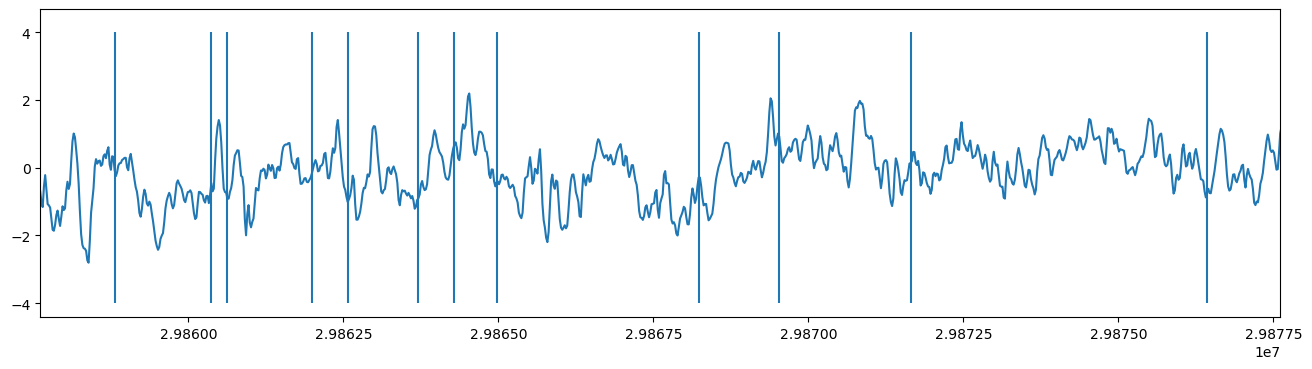

In [31]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trace)
for time_stamp in aligned_spike_times:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

(29857611.0, 29877611.0)

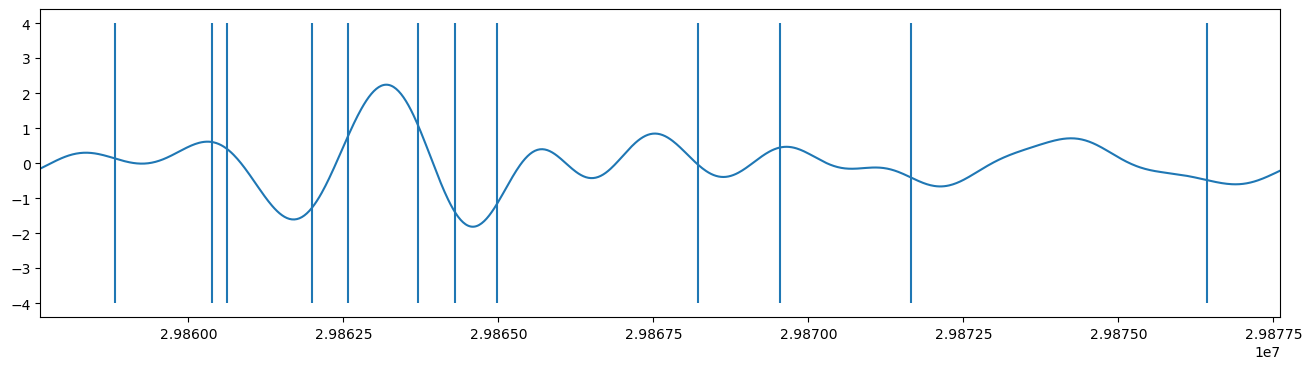

In [32]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_filtered"])
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

(29857611.0, 29877611.0)

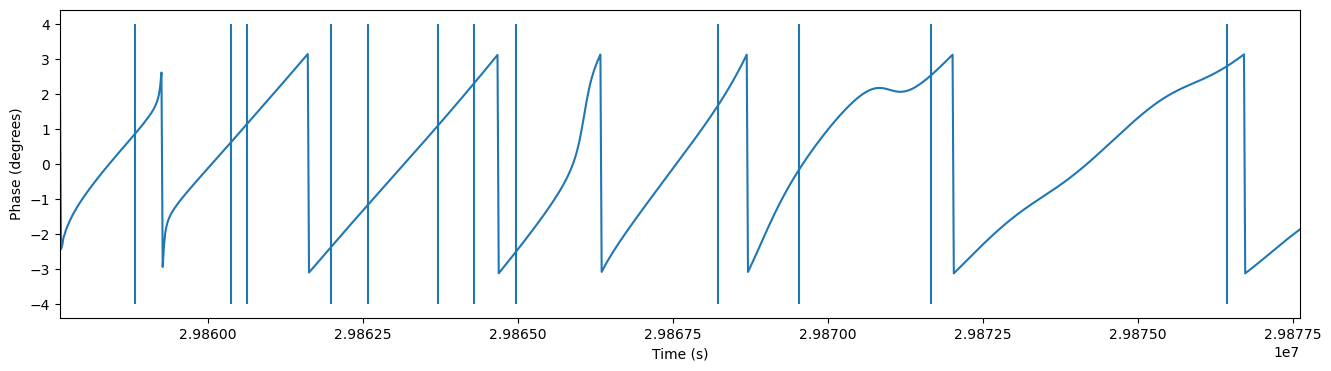

In [33]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_phase"])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [34]:
aligned_spike_indices = find_closest_indices(max_group_data, example_times)

In [35]:
spike_phases = []
for spike_time in aligned_spike_indices:
    spike_phases.append(example_trial["mPFC_trial_phase"][spike_time])


[ 0. 15. 12. 11. 11.  9. 13.  9.  7.  8. 12. 11. 13. 23. 14. 11. 12. 16.
  5.]


<BarContainer object of 19 artists>

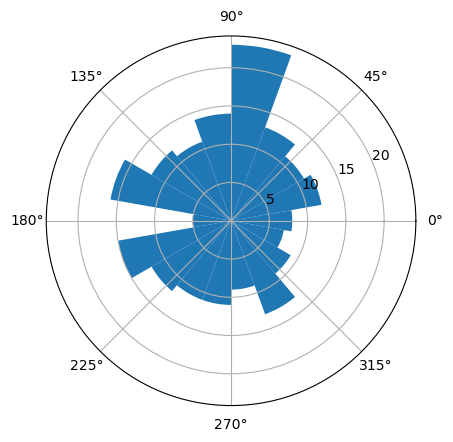

In [36]:
n_bins = 18
phase_bins = np.linspace(-np.pi, np.pi, n_bins+1)
binned_phases = np.digitize(spike_phases, phase_bins, n_bins+1)
spike_phase_hist = np.zeros(n_bins+1)
for bin in range(0, n_bins + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(phase_bins, spike_phase_hist, width=phase_bins[1] - phase_bins[0], bottom=0.0)